# Importing Necessary Libraries:

In [92]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, LSTM, GRU, TextVectorization, Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPool1D, Bidirectional
from tensorflow.keras.layers import Concatenate, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Downloading Helper Functions Script

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-20 13:02:22--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-05-20 13:02:22 (101 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [3]:
from helper_functions import calculate_results

# Data Importing and Pre-Processing

## Imprting The Data:

In [4]:
# Getting Data From Github:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [5]:
# Directory of Data:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# Checking Content of Data Directory:
os.listdir(data_dir)

['train.txt', 'test.txt', 'dev.txt']

## Creating Functions to Pre-Process The Data

In [7]:
# Function to Read Lines from Files in Data Directory:
def get_lines(filename):
  """
      Reads filename (a text file) and returns the lines of text as a list.

      Args:
          filename: a string containing the target filepath to read.

      Returns:
          A list of strings with one string per line from the target filename.
          For example:
          ["this is the first line of filename",
           "this is the second line of filename",
           "..."]
    """

  with open(filename, "r") as f:
    return f.readlines()

In [8]:
train_lines= get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
# Function to Pre-Process The Data in Train, Test and Validation Files:

def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

      Takes in filename, reads its contents and sorts through each line,
      extracting things like the target label, the text of the sentence,
      how many sentences are in the current abstract and what sentence number
      the target line is.

      Args:
          filename: a string of the target text file to read and extract line data
          from.

      Returns:
          A list of dictionaries each containing a line from an abstract,
          the lines label, the lines position in the abstract and the total number
          of lines in the abstract where the line is from. For example:

          [{"target": 'CONCLUSION',
            "text": The study couldn't have gone better, turns out people are kinder than you think",
            "line_number": 8,
            "total_lines": 8}]
  """

  input_data = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_data:

    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""

    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["Target"] = target_text_split[0]
        line_data["Text"] = target_text_split[1]
        line_data["Line_Number"] = abstract_line_number
        line_data["Total_Lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:
      abstract_lines += line

  return abstract_samples

In [10]:
# Getting All File Names from Data Directory in a list:
filenames = [data_dir + filename for filename in os.listdir(data_dir)]

In [11]:
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [12]:
# Getting Data From All Files:
train_data = preprocess_text_with_line_numbers(filenames[1])
val_data = preprocess_text_with_line_numbers(filenames[2])
test_data = preprocess_text_with_line_numbers(filenames[0])

In [13]:
train_data[:5]

[{'Target': 'BACKGROUND',
  'Text': 'This study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .',
  'Line_Number': 0,
  'Total_Lines': 8},
 {'Target': 'RESULTS',
  'Text': 'A post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .',
  'Line_Number': 1,
  'Total_Lines': 8},
 {'Target': 'RESULTS',
  'Text': 'Liver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .',
  'Line_Number': 2,
  'Total_Lines': 8},
 {'Target': 'RESULTS',
  'Text': 'Survival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ %

In [14]:
val_data[:5]

[{'Target': 'BACKGROUND',
  'Text': 'IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'Line_Number': 0,
  'Total_Lines': 9},
 {'Target': 'BACKGROUND',
  'Text': 'It is not clear whether these patients would benefit from antifungal treatment .',
  'Line_Number': 1,
  'Total_Lines': 9},
 {'Target': 'OBJECTIVE',
  'Text': 'We sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .',
  'Line_Number': 2,
  'Total_Lines': 9},
 {'Target': 'METHODS',
  'Text': 'Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'Line_Number': 3,
  'Total_Lines': 9},
 {'Targe

In [15]:
test_data[:5]

[{'Target': 'OBJECTIVE',
  'Text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'Line_Number': 0,
  'Total_Lines': 11},
 {'Target': 'METHODS',
  'Text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'Line_Number': 1,
  'Total_Lines': 11},
 {'Target': 'METHODS',
  'Text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'Line_Number': 2,
  'Total_Lines': 11},
 {'Target': 'METHODS',
  'Text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'Line_Number': 3,
  'Total_Lines': 11},
 {'Target': 'METHODS',
  'Text': 'Secondary outcome measures included the Western Ontari

In [16]:
# Creating DataFrames for Training, validation and Test Data:
train_df = pd.DataFrame(train_data)
val_df = pd.DataFrame(val_data)
test_df = pd.DataFrame(test_data)

In [17]:
train_df.head(15)

,Target,Text,Line_Number,Total_Lines
0,BACKGROUND,This study analyzed liver function abnormaliti...,0,8
1,RESULTS,A post hoc analysis was conducted with the use...,1,8
2,RESULTS,Liver function tests ( LFTs ) were measured at...,2,8
3,RESULTS,Survival analyses were used to assess the asso...,3,8
4,RESULTS,The percentage of patients with abnormal LFTs ...,4,8
5,RESULTS,When mean hemodynamic profiles were compared i...,5,8
6,RESULTS,Multivariable analyses revealed that patients ...,6,8
7,CONCLUSIONS,Abnormal LFTs are common in the ADHF populatio...,7,8
8,CONCLUSIONS,Elevated MELD-XI scores are associated with po...,8,8
9,BACKGROUND,Minimally invasive endovascular aneurysm repai...,0,12


## Getting Data Ready for The Model

In [18]:
# Converting text to List of Sentencts for Each Datasets:

train_sentences = train_df["Text"].to_list()
val_sentences = val_df["Text"].to_list()
test_sentences = test_df["Text"].to_list()

In [19]:
train_df.shape, val_df.shape, test_df.shape

((30135, 4), (30212, 4), (180040, 4))

In [20]:
len(train_sentences), len(val_sentences), len(test_sentences)

(30135, 30212, 180040)

In [21]:
train_df["Target"].to_numpy()

array(['BACKGROUND', 'RESULTS', 'RESULTS', ..., 'RESULTS', 'RESULTS',
       'CONCLUSIONS'], dtype=object)

In [22]:
# Creating Labels as Numerics Labels (Both One-Hot and Label Encoded):

one_hot_encoder = OneHotEncoder(sparse_output= False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["Target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["Target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["Target"].to_numpy().reshape(-1,1))

In [23]:
label_encoder= LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["Target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["Target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["Target"].to_numpy())

In [24]:
train_labels_one_hot, val_labels_one_hot, test_labels_one_hot

(array([[1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]))

In [25]:
train_labels_one_hot.shape , val_labels_one_hot.shape, test_labels_one_hot.shape

((30135, 5), (30212, 5), (180040, 5))

In [26]:
train_labels_encoded, val_labels_encoded, test_labels_encoded

(array([0, 4, 4, ..., 4, 4, 1]),
 array([0, 0, 3, ..., 4, 1, 1]),
 array([3, 2, 2, ..., 4, 1, 1]))

In [27]:
train_labels_encoded.shape, val_labels_encoded.shape, test_labels_encoded.shape

((30135,), (30212,), (180040,))

In [28]:
# Converting Line Number and Total Lines to One hot Encoded Features:

train_line_numbers_one_hot = tf.one_hot(train_df["Line_Number"].to_numpy(), depth= 15)
val_line_numbers_one_hot = tf.one_hot(val_df["Line_Number"].to_numpy(), depth= 15)
test_line_numbers_one_hot = tf.one_hot(test_df["Line_Number"].to_numpy(), depth= 15)

In [29]:
train_total_lines_one_hot = tf.one_hot(train_df["Total_Lines"].to_numpy(), depth= 20)
val_total_lines_one_hot = tf.one_hot(val_df["Total_Lines"].to_numpy(), depth= 20)
test_total_lines_one_hot = tf.one_hot(test_df["Total_Lines"].to_numpy(), depth= 20)

In [30]:
train_line_numbers_one_hot

<tf.Tensor: shape=(30135, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [31]:
train_total_lines_one_hot

<tf.Tensor: shape=(30135, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)>

# Embeddings and Model Creation:

## Token (Word) Embedding

### Pre-Trained Token Embedding

In [32]:
# Importing Pre-Trained Embedding from Tensorflow Hub for Token (Word) Embedding:

tf_hub_token_embedding_layer = hub.KerasLayer(handle= "https://www.kaggle.com/models/google/universal-sentence-encoder/tensorFlow2/universal-sentence-encoder/2",
                                              trainable= False,
                                              name= "Universal_Sentence_Encoder")

### Custom Token Embedding

In [33]:
# Finding Average Number of Words in Training Sentences:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.178463580554173

In [34]:
# Length of Sentence That Covers 95% of training Data:
np.percentile(sent_lens, 95)

55.0

In [35]:
Max_Tokens_Word = 68000 # How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
output_seq_len_word = 55

In [36]:
# Creartin Token Vectorizer:
token_vectorizer = TextVectorization(max_tokens= Max_Tokens_Word,
                                    output_sequence_length= output_seq_len_word,
                                    name= "Token_Vectorizer")

In [37]:
# Adapting Token Vector to Training Words:
token_vectorizer.adapt(train_sentences)

In [38]:
# How Many Words are there in Token Vectorizer Vocabulatry:

token_vect_vocab = token_vectorizer.get_vocabulary()
len(token_vect_vocab)

24854

In [39]:
# Creating Custom Token (Word) Embedding:

token_embed = Embedding(input_dim = len(token_vect_vocab),
                        output_dim= 128,
                        name= "Token_Embedding")

## Character Level Embedding

In [40]:
# Making Function to Split Sentences into Characters:

def split_into_chars(text):
  return " ".join(list(text))

split_into_chars("I am Shailya Gandhi")

'I   a m   S h a i l y a   G a n d h i'

In [41]:
# Generating Character Data from Sentences:

train_chars = [split_into_chars(sentence) for sentence in train_sentences]
val_chars = [split_into_chars(sentence) for sentence in val_sentences]
test_chars = [split_into_chars(sentence) for sentence in test_sentences]

In [42]:
train_chars[0], val_chars[0], test_chars[0]

('T h i s   s t u d y   a n a l y z e d   l i v e r   f u n c t i o n   a b n o r m a l i t i e s   i n   h e a r t   f a i l u r e   p a t i e n t s   a d m i t t e d   w i t h   s e v e r e   a c u t e   d e c o m p e n s a t e d   h e a r t   f a i l u r e   (   A D H F   )   .',
 'I g E   s e n s i t i z a t i o n   t o   A s p e r g i l l u s   f u m i g a t u s   a n d   a   p o s i t i v e   s p u t u m   f u n g a l   c u l t u r e   r e s u l t   a r e   c o m m o n   i n   p a t i e n t s   w i t h   r e f r a c t o r y   a s t h m a   .',
 'T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r 

In [43]:
# Finding Average Number of Characters in Training Sentences:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
char_lens[:10], mean_char_len

([140, 172, 122, 352, 109, 247, 324, 107, 93, 171], 148.45996349759415)

In [44]:
# Length of Sentence That Covers 95% of training Data:
np.percentile(char_lens, 95)

288.0

In [45]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [46]:
Max_Tokens_Char = len(alphabet) + 2 # num characters in alphabet + space + OOV token
output_seq_len_char = 290

In [47]:
# Creating Character Vectorizer:
char_vectorizer = TextVectorization(max_tokens= Max_Tokens_Char,
                                    output_sequence_length= output_seq_len_char,
                                    name= "Char_Vectorizer")

In [48]:
# Adapting Character vectorizer to Training Characters:
char_vectorizer.adapt(train_chars)

In [49]:
# How Many Characters are there in Character Vectorizer Vocabulatry:

char_vect_vocab = char_vectorizer.get_vocabulary()
len(char_vect_vocab)

28

In [50]:
# Creating Custom Character Embedding:

char_embed = Embedding(input_dim = len(char_vect_vocab),
                        output_dim= 25,
                        name= "Char_Embedding")

# Setting Up Mixed Precision for Training:


In [51]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy= "mixed_float16")

In [52]:
mixed_precision.global_policy()

<Policy "mixed_float16">

# Creating Data Pipelines for Model:

In [53]:
# Creating Training Data Pipeline:

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,
                                                    train_char_token_pos_labels))

train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [54]:
# Creating Validation Data Pipeline:

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                               val_total_lines_one_hot,
                                                               val_sentences,
                                                               val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,
                                                  val_char_token_pos_labels))

val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [55]:
# Creating Testing Data Pipeline:

test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))

test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)

test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data,
                                                   test_char_token_pos_labels))

test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [56]:
# Creating Early Stop Callback:

early_stop = EarlyStopping(monitor= "val_loss",
                           patience= 2)

# Creating Model:

In [80]:
# 1. Token Inputs:

token_inputs = Input(shape= [], dtype= tf.string, name= "Token_Inputs")
token_embedding = tf_hub_token_embedding_layer(token_inputs)
token_outputs = Dense(128, activation= "relu")(token_embedding)
token_model = Model(token_inputs, token_outputs)

# 2. Character Inputs:

char_inputs = Input(shape= (1,), dtype= tf.string, name= "Char_Inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeds = char_embed(char_vectors)
char_bi_lstm = Bidirectional(LSTM(25))(char_embeds)
char_model = Model(char_inputs, char_bi_lstm)

# 3. Line Number Inputs:

line_number_inputs = Input(shape= (15,), dtype= tf.float32, name= "Line_Number_Inputs")
x = Dense(32, activation= "relu")(line_number_inputs)
line_number_model = Model(line_number_inputs, x)

# 4. Total Lines Inputs:

total_lines_inputs = Input(shape= (20,), dtype= tf.float32, name= "Total_Line_Inputs")
y = Dense(32, activation= "relu")(total_lines_inputs)
total_line_model = Model(total_lines_inputs, y)

# 5. Creating Hybrid Embedding using Token and Character Embeddings:

combined_embedding = Concatenate(name= "Token_Char_Hybrid_Embedding")([token_model.output,
                                                                       char_model.output])
z = Dense(256, activation= "relu")(combined_embedding)
z = Dropout(0.5)(z)

# 6. Combining Positional Embeddings with Combined Token and Char Embeddings into a Tribrid Embedding:
tribrid_embedding = Concatenate(name= "Tribrid_Pos_Token_Char_Embedding")([line_number_model.output,
                                                                           total_line_model.output,
                                                                           z])

# 7. Output Layer:

output_layer = Dense(5, activation= "softmax", name= "Output_Layer")(tribrid_embedding)

# 8. Creating The Model:

model_preToken_char_pos_emb = Model(inputs= [line_number_model.input,
                                             total_line_model.input,
                                             token_model.input,
                                             char_model.input],
                                    outputs = output_layer)

In [58]:
# Summary of The Model:
model_preToken_char_pos_emb.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Char_Inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Token_Inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 Char_Vectorizer (TextVecto  (None, 290)                  0         ['Char_Inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 Universal_Sentence_Encoder  (None, 512)                  2567978   ['Token_Inputs[0][0]']  

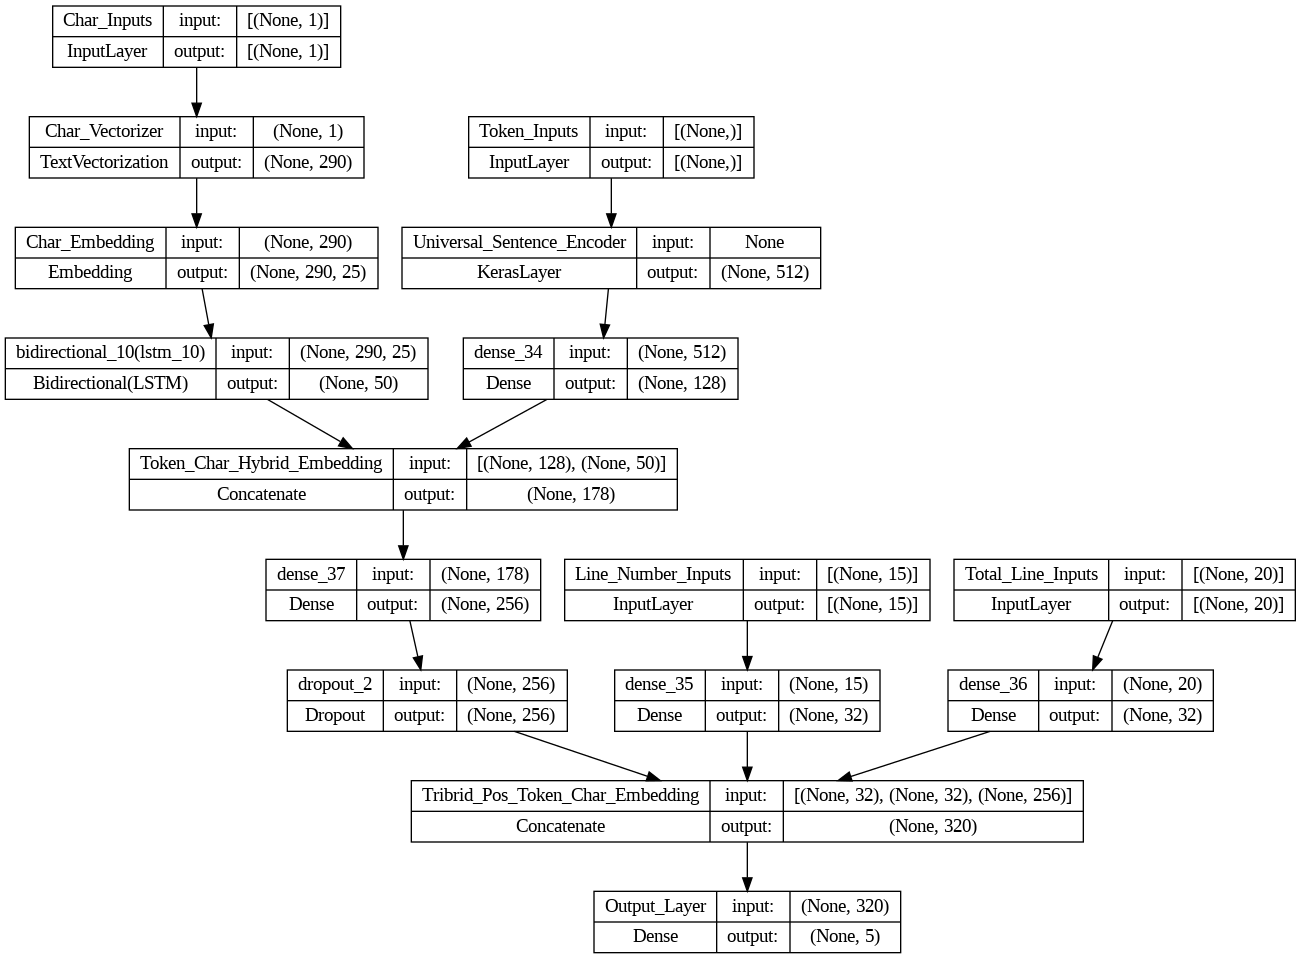

In [94]:
# Plotting The Model:
plot_model(model_preToken_char_pos_emb, show_shapes= True)

In [59]:
# Compiling The Model:

model_preToken_char_pos_emb.compile(optimizer= Adam(),
                                    loss= CategoricalCrossentropy(label_smoothing= 0.2),
                                    metrics= ["accuracy"])

In [61]:
# Fitting The Model:

history_model_preToken_char_pos_emb = model_preToken_char_pos_emb.fit(train_char_token_pos_dataset,
                                                                      validation_data= val_char_token_pos_dataset,
                                                                      epochs= 50,
                                                                      validation_steps= int(0.2 * len(val_char_token_pos_dataset)),
                                                                      callbacks= [early_stop])

Epoch 1/50
942/942 [==============================] - 55s 41ms/step - loss: 1.0542 - accuracy: 0.7511 - val_loss: 0.9549 - val_accuracy: 0.8221
Epoch 2/50
942/942 [==============================] - 37s 40ms/step - loss: 0.9499 - accuracy: 0.8268 - val_loss: 0.9303 - val_accuracy: 0.8373
Epoch 3/50
942/942 [==============================] - 35s 37ms/step - loss: 0.9238 - accuracy: 0.8458 - val_loss: 0.9221 - val_accuracy: 0.8459
Epoch 4/50
942/942 [==============================] - 38s 41ms/step - loss: 0.9055 - accuracy: 0.8600 - val_loss: 0.9185 - val_accuracy: 0.8466
Epoch 5/50
942/942 [==============================] - 40s 42ms/step - loss: 0.8868 - accuracy: 0.8747 - val_loss: 0.9213 - val_accuracy: 0.8426
Epoch 6/50
942/942 [==============================] - 36s 39ms/step - loss: 0.8712 - accuracy: 0.8889 - val_loss: 0.9243 - val_accuracy: 0.8429


# Evaluation of Model on Whole Validation Dataset and Predictions Using The Model:

In [62]:
model_preToken_char_pos_emb.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.9297 - accuracy: 0.8375


[0.9296502470970154, 0.8375148773193359]

In [63]:
# Making Predictions Using The Model:
model_1_pred_probs = model_preToken_char_pos_emb.predict(val_char_token_pos_dataset)
model_1_pred_probs

945/945 [==============================] - 28s 29ms/step


array([[0.6313 , 0.1019 , 0.01582, 0.2362 , 0.01475],
       [0.5757 , 0.0865 , 0.07764, 0.2487 , 0.01175],
       [0.3987 , 0.1016 , 0.0524 , 0.416  , 0.03128],
       ...,
       [0.02689, 0.1578 , 0.0756 , 0.03256, 0.707  ],
       [0.02608, 0.61   , 0.0977 , 0.02095, 0.2454 ],
       [0.0734 , 0.849  , 0.04532, 0.01427, 0.01793]], dtype=float16)

In [64]:
# Converting Model Prediction Probabilities to Claas labels:
model_1_preds = tf.argmax(model_1_pred_probs, axis= 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [65]:
# Calculating Results for the Model:
model_1_results = calculate_results(y_true= val_labels_encoded,
                                    y_pred= model_1_preds)
model_1_results

{'accuracy': 83.75148947438103,
 'precision': 0.8376914851964831,
 'recall': 0.8375148947438104,
 'f1': 0.8356080133076166}

# Creating Model with Custom Embeddings for Tokens (Words)

In [96]:
# 1. Token Inputs:

token_inputs = Input(shape= [], dtype= tf.string, name= "Token_Inputs")
# print(token_inputs.shape)
token_vectors = token_vectorizer(token_inputs)
# print(token_vectors.shape)
token_embedding = token_embed(token_vectors)
# print(token_embedding.shape)
x = GlobalMaxPool1D()(token_embedding)
token_outputs = Dense(128, activation= "relu")(x)
# print(token_outputs.shape)
token_model = Model(token_inputs, token_outputs)

# 2. Character Inputs:

char_inputs = Input(shape= (1,), dtype= tf.string, name= "Char_Inputs")
# print(char_inputs.shape)
char_vectors = char_vectorizer(char_inputs)
# print(char_vectors.shape)
char_embeds = char_embed(char_vectors)
# print(char_embeds.shape)
char_bi_lstm = Bidirectional(LSTM(25))(char_embeds)
# print(char_bi_lstm.shape)
char_model = Model(char_inputs, char_bi_lstm)

# 3. Line Number Inputs:

line_number_inputs = Input(shape= (15,), dtype= tf.float32, name= "Line_Number_Inputs")
x = Dense(32, activation= "relu")(line_number_inputs)
line_number_model = Model(line_number_inputs, x)

# 4. Total Lines Inputs:

total_lines_inputs = Input(shape= (20,), dtype= tf.float32, name= "Total_Line_Inputs")
y = Dense(32, activation= "relu")(total_lines_inputs)
total_line_model = Model(total_lines_inputs, y)

# 5. Creating Hybrid Embedding using Token and Character Embeddings:
combined_embedding = Concatenate(name= "Token_Char_Hybrid_Embedding")([token_model.output,
                                                                       char_model.output])
z = Dense(256, activation= "relu")(combined_embedding)
z = Dropout(0.5)(z)

# 6. Combining Positional Embeddings with Combined Token and Char Embeddings into a Tribrid Embedding:
tribrid_embedding = Concatenate(name= "Tribrid_Pos_Token_Char_Embedding")([line_number_model.output,
                                                                           total_line_model.output,
                                                                           z])

# 7. Output Layer:

output_layer = Dense(5, activation= "softmax", name= "Output_Layer")(tribrid_embedding)

# 8. Creating The Model:

model_cusToken_char_pos_emb = Model(inputs= [line_number_model.input,
                                             total_line_model.input,
                                             token_model.input,
                                             char_model.input],
                                    outputs = output_layer)

In [97]:
# Summary of The Model:
model_cusToken_char_pos_emb.summary()

Model: "model_68"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Token_Inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 Token_Vectorizer (TextVect  (None, 55)                   0         ['Token_Inputs[0][0]']        
 orization)                                                                                       
                                                                                                  
 Char_Inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Token_Embedding (Embedding  (None, 55, 128)              3181312   ['Token_Vectorizer[11][

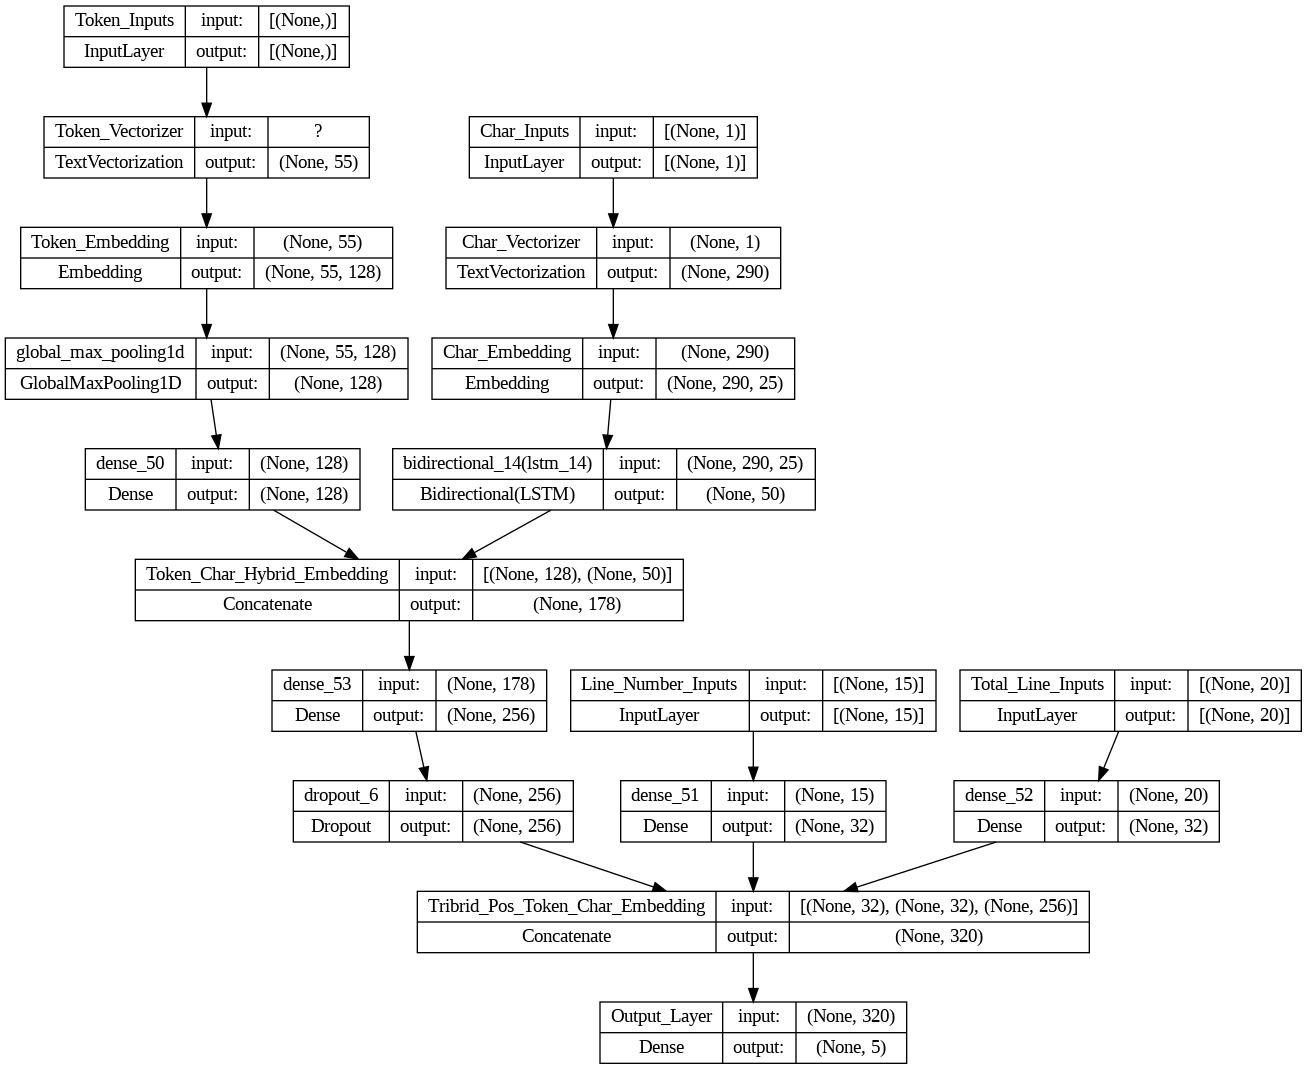

In [98]:
# Plotting The Model:
plot_model(model_cusToken_char_pos_emb, show_shapes= True)

In [99]:
# Compiling The Model:

model_cusToken_char_pos_emb.compile(optimizer= Adam(),
                                    loss= CategoricalCrossentropy(label_smoothing= 0.2),
                                    metrics= ["accuracy"])

In [100]:
# Fitting The Model:

history_model_cusToken_char_pos_emb = model_cusToken_char_pos_emb.fit(train_char_token_pos_dataset,
                                                                      validation_data= val_char_token_pos_dataset,
                                                                      epochs= 50,
                                                                      validation_steps= int(0.2 * len(val_char_token_pos_dataset)),
                                                                      callbacks= [early_stop])

Epoch 1/50
942/942 [==============================] - 50s 46ms/step - loss: 0.9099 - accuracy: 0.8662 - val_loss: 0.9651 - val_accuracy: 0.8226
Epoch 2/50
942/942 [==============================] - 27s 29ms/step - loss: 0.7780 - accuracy: 0.9517 - val_loss: 0.9688 - val_accuracy: 0.8135
Epoch 3/50
942/942 [==============================] - 28s 30ms/step - loss: 0.7351 - accuracy: 0.9763 - val_loss: 0.9842 - val_accuracy: 0.8089


In [101]:
# Evaluaating Model on Whole Validation Data:
model_cusToken_char_pos_emb.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 12s 13ms/step - loss: 0.9922 - accuracy: 0.8028


[0.9922226667404175, 0.8028267025947571]

In [102]:
# Making Predictions Using The Model:
model_2_pred_probs = model_cusToken_char_pos_emb.predict(val_char_token_pos_dataset)
model_2_pred_probs

945/945 [==============================] - 12s 12ms/step


array([[0.859  , 0.01572, 0.02083, 0.0695 , 0.03488],
       [0.5215 , 0.05853, 0.0805 , 0.2607 , 0.07886],
       [0.464  , 0.1007 , 0.0876 , 0.2615 , 0.08624],
       ...,
       [0.0284 , 0.0618 , 0.0397 , 0.03207, 0.838  ],
       [0.0889 , 0.7705 , 0.04648, 0.02135, 0.0731 ],
       [0.04245, 0.863  , 0.0449 , 0.02046, 0.02919]], dtype=float16)

In [103]:
# Converting Model Prediction Probabilities to Claas labels:
model_2_preds = tf.argmax(model_2_pred_probs, axis= 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 0, ..., 4, 1, 1])>

In [104]:
# Calculating Results for the Model:
model_2_results = calculate_results(y_true= val_labels_encoded,
                                    y_pred= model_2_preds)
model_2_results

{'accuracy': 80.28266913809082,
 'precision': 0.8007182279883703,
 'recall': 0.8028266913809082,
 'f1': 0.801233905368123}

# Comparing Two Models:

In [105]:
# Creating DataFrame of Two Model's Results:
results = pd.DataFrame({"Pre-Trained Token Embeddings Model": model_1_results,
                        "Custom Token Embeddings": model_2_results})

In [107]:
results = results.T
results

,accuracy,precision,recall,f1
Pre-Trained Token Embeddings Model,83.751489,0.837691,0.837515,0.835608
Custom Token Embeddings,80.282669,0.800718,0.802827,0.801234


In [109]:
# Changing Accuracy to Same Scale as Other Metrics:
results["accuracy"] = results["accuracy"] / 100
results

,accuracy,precision,recall,f1
Pre-Trained Token Embeddings Model,0.837515,0.837691,0.837515,0.835608
Custom Token Embeddings,0.802827,0.800718,0.802827,0.801234


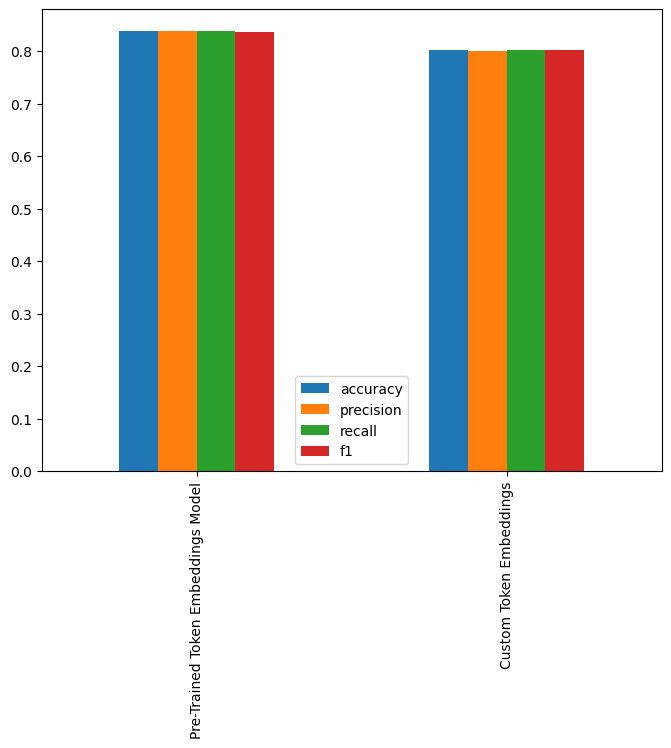

In [111]:
# Plotting and Comparing Metrics of Both Models:
results.plot(kind= "bar", figsize= (8,6));